In [23]:
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel("D:\Tiger\Modelling_Assignment\DS Internship - Modeling - Data.xlsx")
data.head()

,Store ID,Pop class,Sales,Centre Type,Climate,Total Store Sq Ft,Sales Floor Sq Ft,Girls Sq Ft,Guys Sq Ft,Accessories Sq Ft,...,Poverty: In poverty,Male 14 to 35 CrYr,Female 14 to 35 CrYr,Total Pop 14 to 35 CrYr,Under 25 Low Income,Under 25 Med Income,Under 25 High Income,25 to 44 Low Income,25 to 44 Med Income,25 to 44 High Income
0,1,Suburban,1345251.88,Outlet,Frigid,4735.0,4015.6,2032.3,947.7,747.5,...,1680,4444,4095,8539,74,285,7,683,1692,1291
1,2,Urban,1669906.40,Mall,Moderate,8068.0,7128.6,2735.2,1788.1,1251.3,...,21003,58486,52872,111358,1317,1396,358,11104,21417,20357
2,3,Urban,2528042.74,Outlet,Hot,4583.2,3961.7,2082.9,1030.2,551.7,...,107701,286481,275998,562479,14977,11109,2870,63228,120359,99407
3,4,Suburban,1281613.45,Outlet,Moderate,5772.3,4713.0,2140.1,1149.0,1162.2,...,23477,45764,43429,89193,5135,2426,512,10011,15485,9238
4,5,Urban,1278092.87,Outlet,Cold,3503.0,3239.0,1870.6,769.5,483.5,...,65968,157166,152880,310046,11249,6220,2311,32448,57978,74382


In [4]:
print("Missing values:\n", data.isnull().sum())
data = data.drop('Store ID', axis=1)

Missing values:
 Store ID                           0
Pop class                          0
Sales                              0
Centre Type                        0
Climate                            0
Total Store Sq Ft                  0
Sales Floor Sq Ft                  0
Girls Sq Ft                        6
Guys Sq Ft                         5
Accessories Sq Ft                  6
Guys Segmentation                  0
Girls Segmentation                 0
ChangeMade                         0
ChangeDate                       412
Population Est CrYr                0
Transient Pop Est                  0
Seasonal Pop Est                   0
Sex Males CrYr                     0
Sex Females CrYr                   0
Age Average CrYr                   0
Unemployment Rate                  0
Average Household Income CrYr      0
Householder under 25 years:        0
Householder 25 to 44 years:        0
Family Inc: Aggregate Average      0
Per Capita Income CrYr             0
Wealth: Average House

In [5]:
categorical_cols = ['Pop class', 'Centre Type', 'Climate', 'Guys Segmentation', 
                   'Girls Segmentation', 'ChangeMade']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [6]:
# Convert ChangeDate
data['ChangeDate'] = pd.to_datetime(data['ChangeDate'])
reference_date = pd.to_datetime('2020-01-01')
data['DaysSinceChange'] = (reference_date - data['ChangeDate']).dt.days
data = data.drop('ChangeDate', axis=1)

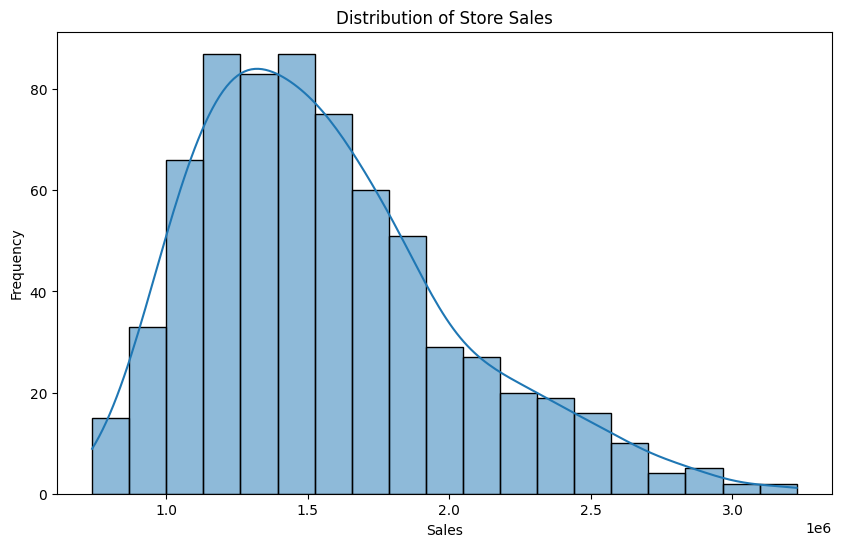

In [7]:
# EDA - Sales Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Sales'], kde=True)
plt.title('Distribution of Store Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

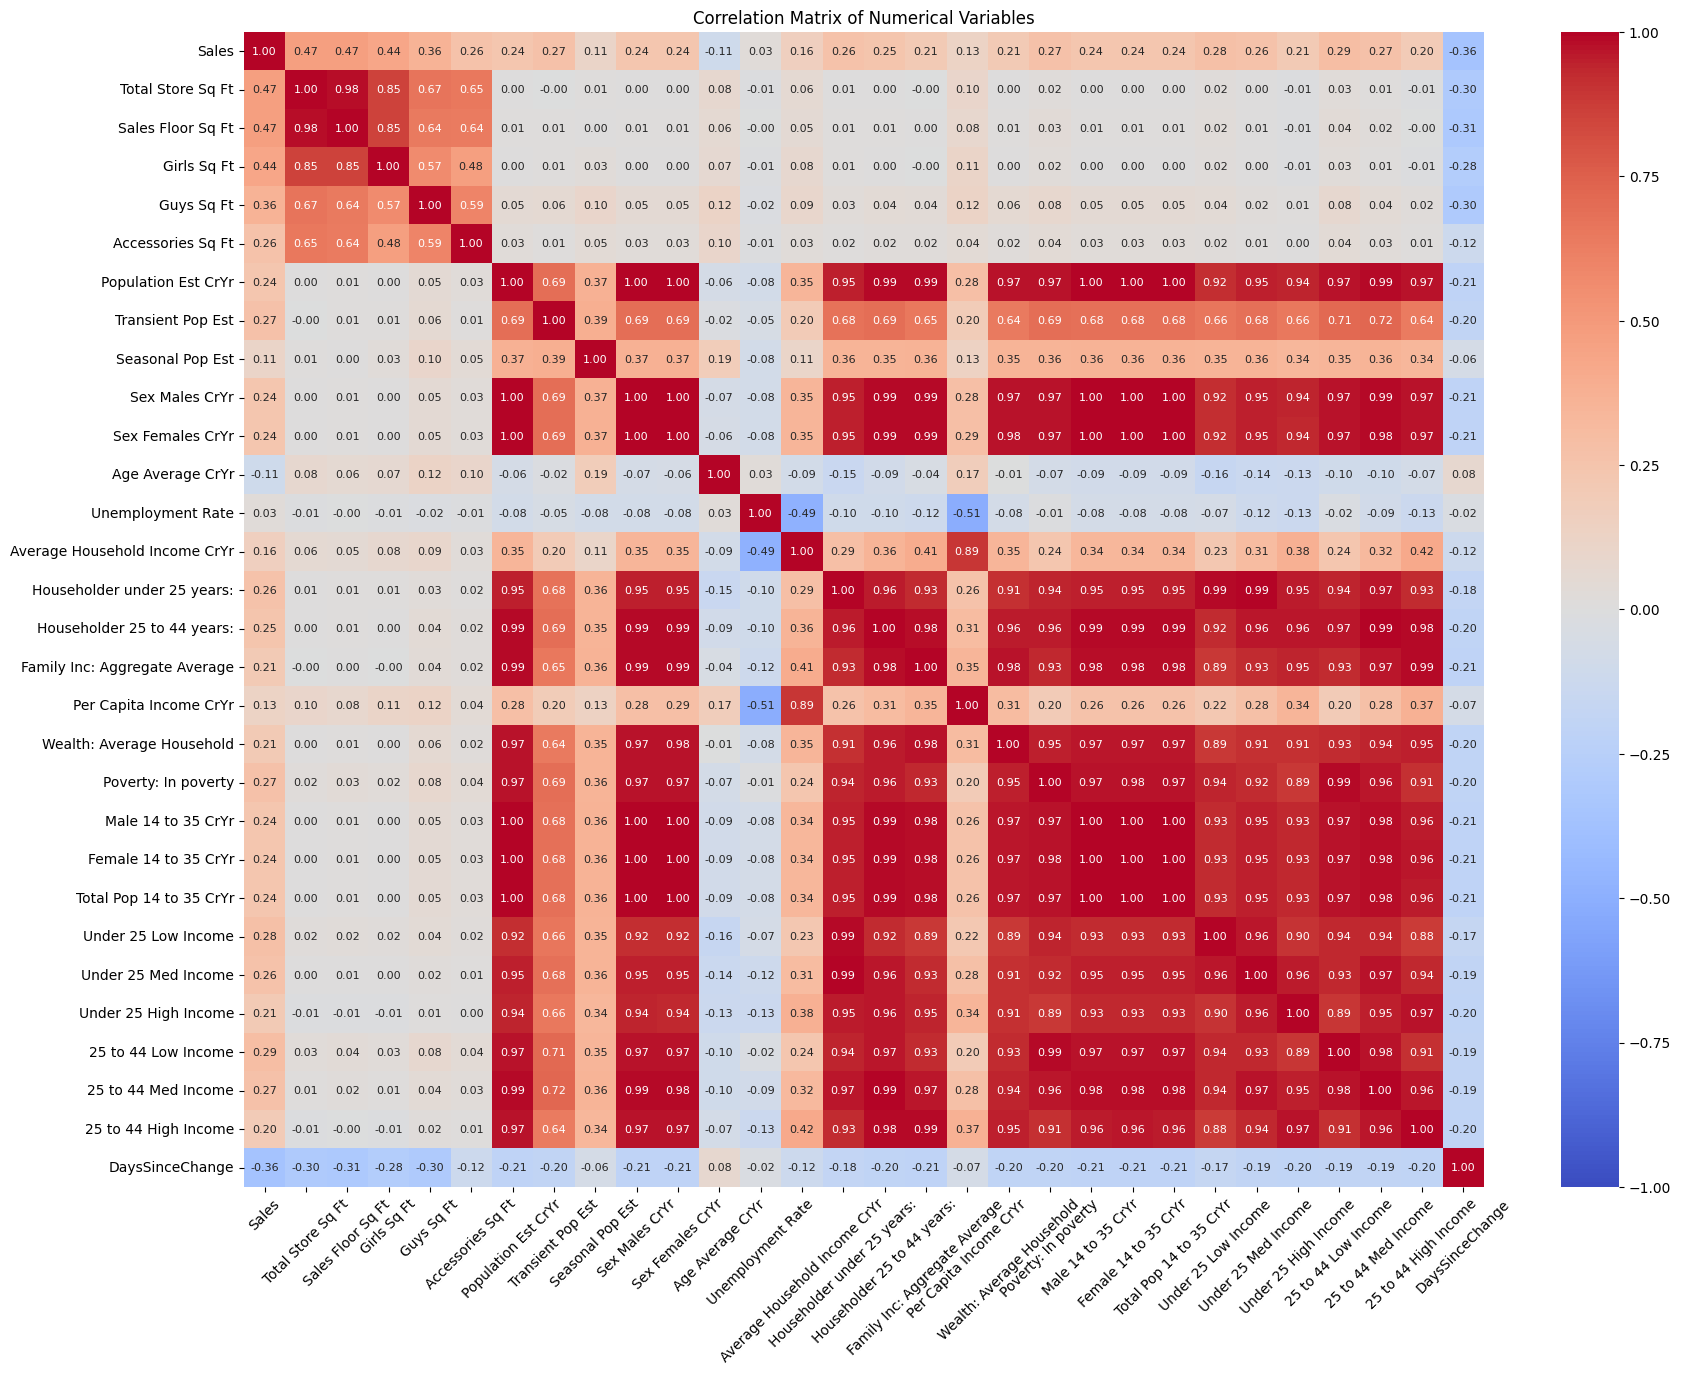

In [8]:
# Correlation Matrix
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data[numerical_cols].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
           annot_kws={"size": 8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [9]:
#VIF Calculation with Error Handling

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for numeric features only
    Handles potential data type issues and infinite values
    """

    X_numeric = X.select_dtypes(include=['int64', 'float64'])
    
    # Drop columns with NaN or infinite values
    X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    
    # Initialize VIF DataFrame
    vif = pd.DataFrame()
    vif["variables"] = X_numeric.columns
    
    try:
        # Calculate VIF for each numeric column
        vif["VIF"] = [variance_inflation_factor(X_numeric.values, i) 
                     for i in range(X_numeric.shape[1])]
    except Exception as e:
        print(f"Error calculating VIF: {str(e)}")
        # If error occurs, try dropping constant columns
        X_numeric = X_numeric.loc[:, X_numeric.std() > 0.1]  # Drop near-constant columns
        vif["VIF"] = [variance_inflation_factor(X_numeric.values, i) 
                     for i in range(X_numeric.shape[1])]
    
    return vif

# Prepare features and target
X = data.drop('Sales', axis=1)
y = data['Sales']

# Calculate VIF
vif_data = calculate_vif(X)

# Display sorted VIF results
print("Initial VIF (numeric features only):\n", 
      vif_data.sort_values('VIF', ascending=False))

# Optional: Show non-numeric columns that were excluded
non_numeric_cols = set(X.columns) - set(vif_data['variables'])
if non_numeric_cols:
    print("\nNote: These non-numeric columns were excluded from VIF calculation:")
    print(non_numeric_cols)

Initial VIF (numeric features only):
                         variables           VIF
16             Male 14 to 35 CrYr           inf
17           Female 14 to 35 CrYr           inf
18        Total Pop 14 to 35 CrYr           inf
2             Population Est CrYr  1.725517e+12
6                Sex Females CrYr  4.444269e+11
5                  Sex Males CrYr  4.186085e+11
11    Householder 25 to 44 years:  5.782382e+09
24           25 to 44 High Income  1.177294e+09
23            25 to 44 Med Income  7.677620e+08
22            25 to 44 Low Income  2.261988e+08
10    Householder under 25 years:  7.581806e+07
19            Under 25 Low Income  1.706937e+07
20            Under 25 Med Income  1.206873e+07
21           Under 25 High Income  1.466807e+06
12  Family Inc: Aggregate Average  1.376994e+03
0               Total Store Sq Ft  7.365826e+02
1               Sales Floor Sq Ft  6.237832e+02
15            Poverty: In poverty  5.942356e+02
13         Per Capita Income CrYr  2.573190e+02
9 

Features with VIF > 10 (high multicollinearity):
 ['Total Store Sq Ft', 'Sales Floor Sq Ft', 'Population Est CrYr', 'Sex Males CrYr', 'Sex Females CrYr', 'Age Average CrYr', 'Unemployment Rate', 'Average Household Income CrYr', 'Householder under 25 years:', 'Householder 25 to 44 years:', 'Family Inc: Aggregate Average', 'Per Capita Income CrYr', 'Wealth: Average Household', 'Poverty: In poverty', 'Male 14 to 35 CrYr', 'Female 14 to 35 CrYr', 'Total Pop 14 to 35 CrYr', 'Under 25 Low Income', 'Under 25 Med Income', 'Under 25 High Income', '25 to 44 Low Income', '25 to 44 Med Income', '25 to 44 High Income']

All features being removed:
 ['Under 25 Low Income', 'Wealth: Average Household', 'Under 25 High Income', '25 to 44 Low Income', 'Average Household Income CrYr', 'Male 14 to 35 CrYr', 'Sales Floor Sq Ft', 'Sex Males CrYr', 'Total Pop 14 to 35 CrYr', 'Female 14 to 35 CrYr', 'Total Store Sq Ft', 'Family Inc: Aggregate Average', '25 to 44 Med Income', 'Poverty: In poverty', 'Under 25 M

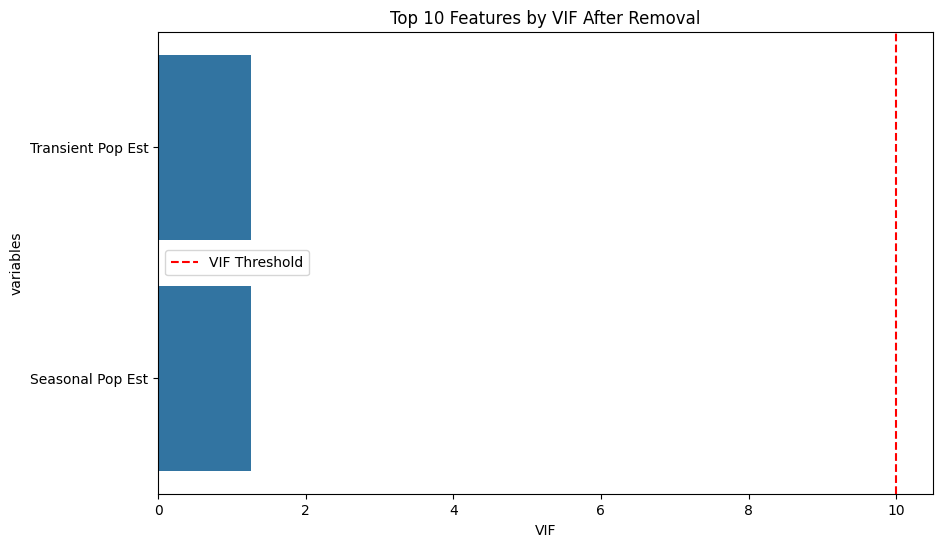


All remaining features have VIF ≤ 10

Original number of features: 43
Reduced number of features: 20
Features removed: 23


In [10]:
#Feature Selection Based on VIF Analysis
high_vif_features = vif_data[vif_data['VIF'] > 10]['variables'].tolist()
print("Features with VIF > 10 (high multicollinearity):\n", high_vif_features)

# Business-driven features to remove
business_remove_features = [
    'Total Store Sq Ft',  
    'Sex Males CrYr', 'Sex Females CrYr',  
    'Total Pop 14 to 35 CrYr',  
    'Family Inc: Aggregate Average', 
    'Wealth: Average Household',  
    'Householder under 25 years:', 
    'Householder 25 to 44 years:'  
]

# combine
features_to_remove = list(set(high_vif_features + business_remove_features))
print("\nAll features being removed:\n", features_to_remove)

# Create reduced feature set
X_reduced = X.drop(features_to_remove, axis=1, errors='ignore')  # errors='ignore' prevents errors if some features don't exist

# Verify removal by recalculating VIF
print("\nRecalculating VIF after feature removal...")
vif_reduced = calculate_vif(X_reduced)

# Display results
print("\nReduced VIF values:\n", vif_reduced.sort_values('VIF', ascending=False))

# Visualize remaining high VIF features
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='variables', data=vif_reduced.sort_values('VIF', ascending=False).head(10))
plt.title('Top 10 Features by VIF After Removal')
plt.axvline(x=10, color='r', linestyle='--', label='VIF Threshold')
plt.legend()
plt.show()

# Final check for remaining high VIF features
remaining_high_vif = vif_reduced[vif_reduced['VIF'] > 10]['variables'].tolist()
if remaining_high_vif:
    print("\nWarning: These features still have VIF > 10:")
    print(remaining_high_vif)
else:
    print("\nAll remaining features have VIF ≤ 10")

# Prepare for next step
print("\nOriginal number of features:", X.shape[1])
print("Reduced number of features:", X_reduced.shape[1])
print("Features removed:", len(features_to_remove))

In [11]:
#Train-Test Split 
y_bins = pd.qcut(y, q=4, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y_bins)

print(f"\nTraining set size: {X_train.shape[0]} stores")
print(f"Test set size: {X_test.shape[0]} stores")

print("\nSales distribution in train set:")
print(y_train.describe())
print("\nSales distribution in test set:")
print(y_test.describe())


Training set size: 552 stores
Test set size: 139 stores

Sales distribution in train set:
count    5.520000e+02
mean     1.557209e+06
std      4.495560e+05
min      7.376623e+05
25%      1.223069e+06
50%      1.484378e+06
75%      1.816482e+06
max      3.226827e+06
Name: Sales, dtype: float64

Sales distribution in test set:
count    1.390000e+02
mean     1.590025e+06
std      4.929056e+05
min      8.296007e+05
25%      1.224823e+06
50%      1.477147e+06
75%      1.814555e+06
max      3.181289e+06
Name: Sales, dtype: float64


In [15]:
#Linear Regression Model with Robust Data Cleaning

from sklearn.preprocessing import StandardScaler
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce').replace([np.inf, -np.inf], np.nan)
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce').replace([np.inf, -np.inf], np.nan)

print("Missing values before imputation:")
print(X_train[numeric_cols].isna().sum())

X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].mean())
X_test[numeric_cols] = X_test[numeric_cols].fillna(X_train[numeric_cols].mean())  # Use train means for test set
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
print("\nData validation check:")
print("Infinite values in train:", np.isinf(X_train[numeric_cols].values).sum())
print("NaN values in train:", np.isnan(X_train[numeric_cols].values).sum())

X_train_sm = sm.add_constant(X_train.astype(float))
X_test_sm = sm.add_constant(X_test.astype(float))

try:
    model = sm.OLS(y_train.astype(float), X_train_sm.astype(float))
    results = model.fit()
    print("\nModel summary:")
    print(results.summary())
except Exception as e:
    print(f"\nModel failed to fit: {str(e)}")
    print("Debugging info:")
    print("X_train dtypes:", X_train_sm.dtypes.value_counts())
    print("y_train dtype:", y_train.dtype)

Missing values before imputation:
Girls Sq Ft            6
Guys Sq Ft             5
Accessories Sq Ft      6
Transient Pop Est      0
Seasonal Pop Est       0
DaysSinceChange      323
dtype: int64

Data validation check:
Infinite values in train: 0
NaN values in train: 0

Model summary:
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     23.42
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           2.98e-60
Time:                        12:14:54   Log-Likelihood:                -7793.1
No. Observations:                 552   AIC:                         1.563e+04
Df Residuals:                     531   BIC:                         1.572e+04
Df Model:                          20                                         
C

In [16]:
#Model Evaluation

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

# Predictions
y_train_pred = results.predict(X_train_sm)
y_test_pred = results.predict(X_test_sm)

# Calculate metrics
metrics = {
    'Train': {
        'R2': r2_score(y_train, y_train_pred),
        'Adj R2': 1 - (1-r2_score(y_train, y_train_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MAPE': mean_absolute_percentage_error(y_train, y_train_pred)
    },
    'Test': {
        'R2': r2_score(y_test, y_test_pred),
        'Adj R2': 1 - (1-r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAPE': mean_absolute_percentage_error(y_test, y_test_pred)
    }
}

metrics_df = pd.DataFrame(metrics)
print("\nModel Performance Metrics:")
print(metrics_df)


Model Performance Metrics:
               Train          Test
R2      4.686408e-01  4.359239e-01
Adj R2  4.486272e-01  3.403177e-01
MAE     2.580556e+05  2.719069e+05
MSE     1.071934e+11  1.360597e+11
RMSE    3.274041e+05  3.688627e+05
MAPE    1.705707e+01  1.710436e+01


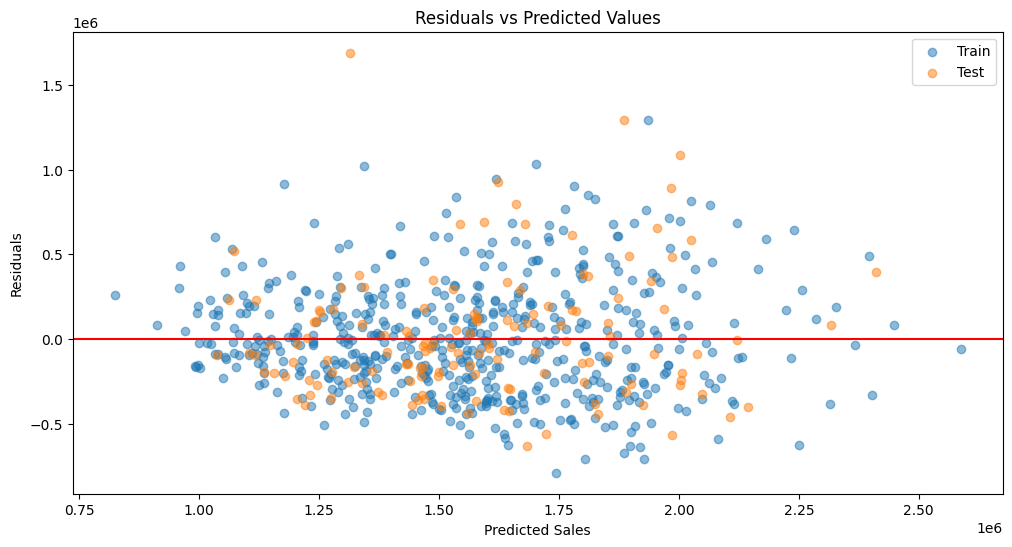

In [17]:
#Residual Analysis
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(12, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.5, label='Train')
plt.scatter(y_test_pred, test_residuals, alpha=0.5, label='Test')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

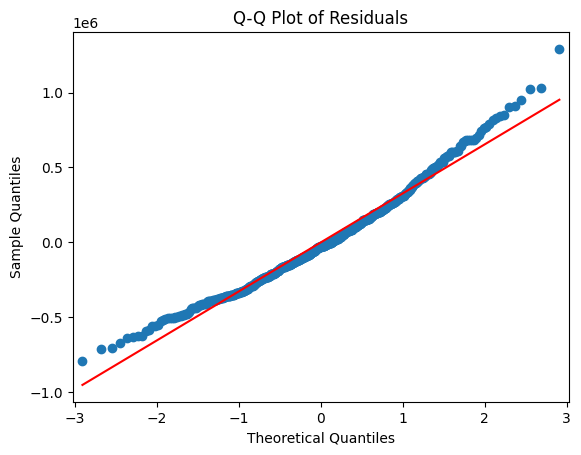

In [18]:
#Q-Q Plot

plt.figure(figsize=(8, 6))
sm.qqplot(train_residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [19]:
#Feature Importance

coefficients = pd.DataFrame({
    'Feature': X_train_sm.columns,
    'Coefficient': results.params,
    'P-value': results.pvalues
}).round(4)

significant_features = coefficients[coefficients['P-value'] < 0.05].sort_values(
    by='Coefficient', ascending=False)

print("\nSignificant Features (p-value < 0.05):")
print(significant_features[['Feature', 'Coefficient']])


Significant Features (p-value < 0.05):
                                               Feature   Coefficient
const                                            const  1.677392e+06
Centre Type_Outlet                  Centre Type_Outlet  1.763026e+05
Pop class_Urban                        Pop class_Urban  1.328252e+05
Climate_Hot                                Climate_Hot  1.159157e+05
Girls Sq Ft                                Girls Sq Ft  9.818153e+04
Transient Pop Est                    Transient Pop Est  5.831294e+04
DaysSinceChange                        DaysSinceChange -6.122175e+04
Centre Type_Strip                    Centre Type_Strip -8.692236e+04
ChangeMade_no change              ChangeMade_no change -1.734089e+05
Guys Segmentation_On trend  Guys Segmentation_On trend -4.249298e+05


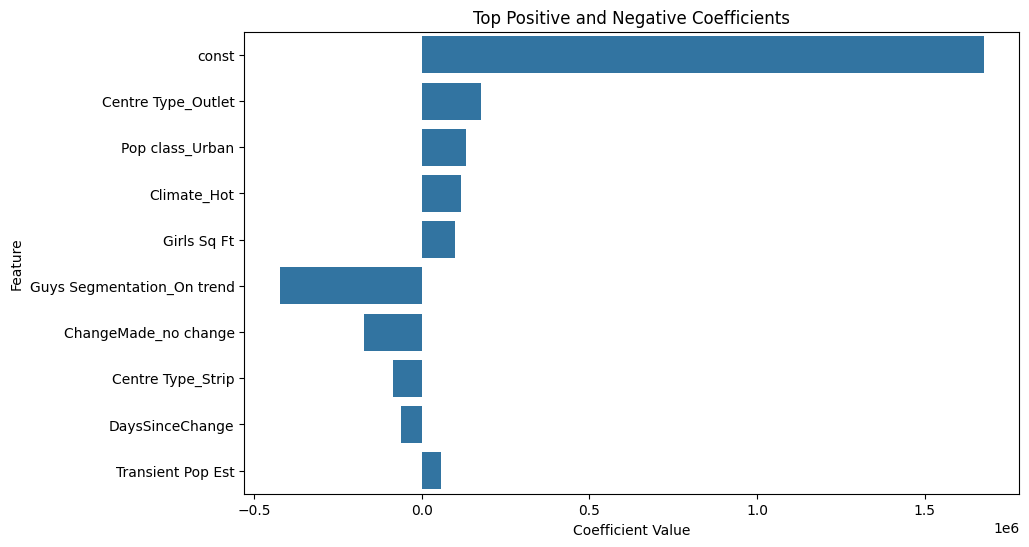

In [20]:
#Top Features Visualization

top_features = pd.concat([
    significant_features.nlargest(5, 'Coefficient'),
    significant_features.nsmallest(5, 'Coefficient')
])

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.title('Top Positive and Negative Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [21]:
#Export Results

model_summary = results.summary().as_text()
metrics_output = metrics_df.transpose()

with pd.ExcelWriter('ABC_Store_Sales_Model_Results_Final.xlsx') as writer:
    pd.DataFrame([model_summary]).to_excel(writer, sheet_name='Model Summary', index=False, header=False)
    metrics_output.to_excel(writer, sheet_name='Model Metrics')
    significant_features.to_excel(writer, sheet_name='Significant Features', index=False)
    coefficients.to_excel(writer, sheet_name='All Coefficients', index=False)

print("Model results exported to ABC_Store_Sales_Model_Results_Final.xlsx")

Model results exported to ABC_Store_Sales_Model_Results_Final.xlsx


In [22]:
#Key Findings
print("\nKey Findings:")
print(f"1. Model achieved test MAPE of {metrics['Test']['MAPE']:.2f}%")
print("2. Top positive drivers:")
print(significant_features.nlargest(3, 'Coefficient')[['Feature', 'Coefficient']].to_string(index=False))
print("\n3. Top negative factors:")
print(significant_features.nsmallest(3, 'Coefficient')[['Feature', 'Coefficient']].to_string(index=False))

print("\nRecommendations:")
print("1. Prioritize locations with larger sales floor areas and affluent demographics")
print("2. Avoid areas with high unemployment or poverty rates")
print("3. Consider center type (mall/outlet) based on coefficient signs")


Key Findings:
1. Model achieved test MAPE of 17.10%
2. Top positive drivers:
           Feature  Coefficient
             const 1677392.4195
Centre Type_Outlet  176302.5559
   Pop class_Urban  132825.2251

3. Top negative factors:
                   Feature  Coefficient
Guys Segmentation_On trend -424929.8094
      ChangeMade_no change -173408.8583
         Centre Type_Strip  -86922.3647

Recommendations:
1. Prioritize locations with larger sales floor areas and affluent demographics
2. Avoid areas with high unemployment or poverty rates
3. Consider center type (mall/outlet) based on coefficient signs
